In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative

In [2]:
metaserieses = [17 for _ in range(81)]
serieses = [i for i in range(81)]

series_names = None

series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [3]:
experiment_info = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    config = configs_exp["0.yaml"]
    configs[series] = config
    experiment_info[series] = config["experiment_info"]

In [4]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [5]:
durations = {}
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes_gurobi(
        adaptation_log=adaptation_logs[series]
    )
    durations[series] = sum(series_changes[series]["duration"]) / len(series_changes[series]["duration"])

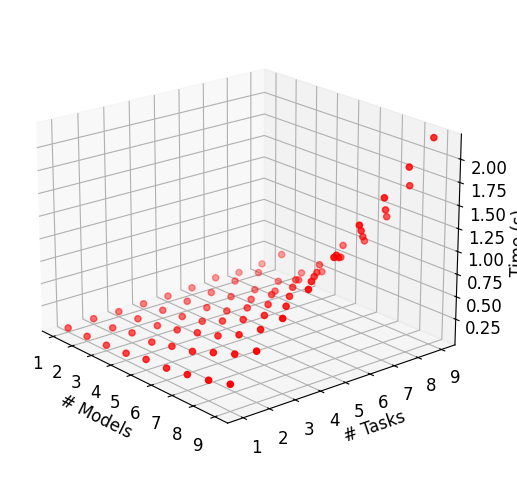

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample dictionary
data = {}
for key, value in durations.items():
    data[(experiment_info[key]['models_num'], experiment_info[key]['tasks_num'])] = value

# Extract the x, y, and z values from the dictionary
x = [coord[0] for coord in data.keys()]
y = [coord[1] for coord in data.keys()]
z = list(data.values())

# Adjust figure size and subplot layout
fig = plt.figure(figsize=(6, 6))
# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

# Create the axis
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
ax.scatter(x, y, z, c='r', marker='o')

# Set z-axis limits
ax.set_zlim(min(z), max(z))

# Add labels and title
ax.set_xlabel('# Models')
ax.set_ylabel('# Tasks')
ax.set_zlabel('Time (s)')

# Rotate the plot view
ax.view_init(elev=20, azim=-40)

# Add a bold line at y=0.5
ax.axhline(y=0.5, color='black', linewidth=2)

# plt.tight_layout()
# Display the plot
# TODO needed to be cropped manually at the end
plt.savefig(fname=f"{FIGURES_PATH}/gorubi-scalibility.pdf")
